# Evidence of an Accelerating Universe from Type Ia Supernovae
Author: João Victor Silva Rebouças, July 2024

One of the most intriguing challenges in current physics is to explain dark energy, the physical mechanism driving an accelerated expansion of the Universe. Strong evidence of dark energy was first reported in 1998, by two teams: the High-z Supernovae Search Team, led by Adam Riess, and the Supernovae Cosmology Project, led by Saul Perlmutter. Both of them shared the 2011 Nobel Prize in Physics.

This notebook tries to replicate and extend the data analysis from Riess' et. al. article [Evidence of an Accelerating Universe from Type Ia Supernovae](https://arxiv.org/abs/astro-ph/9805201) in light of a data-driven, precision cosmology era. The main goal is to reproduce the following figure:

![SN](riess_figure.png "Evidence for Accelerating Universe")

In [17]:
from random import uniform
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
import getdist
from getdist import plots

The data consists of the *distance moduli* $\mu$ of many supernovae, marked by the redshift $z$. $\mu$ is related to the luminosity distance by the relation (Equation 3 from the paper):

$$\mu = 5 \log(D_L/1\mathrm{Mpc}) + 25$$

![alt text](mlcs.png "SN data")
![alt text](highz.png "SN data")

In [18]:
c = 3e5 # km/s

class SN:
    def __init__(self, mu, sigma_mu, z=None, logcz=None, name=""):
        self.name = name
        if logcz is not None:
            self.z = 10**logcz/c
        else:
            self.z = z
        self.mu = mu
        self.sigma_mu = sigma_mu
        self.DL = 10**((self.mu - 25)/5) # in Mpc
        self.sigma_DL = 10**((self.mu - 25)/5)*np.log(10)/5*sigma_mu # in Mpc

mlcs = [
    SN(logcz=3.734, mu=34.72, sigma_mu=0.16, name="1992bo"),
    SN(logcz=3.779, mu=34.87, sigma_mu=0.11, name="1992bc"),
    SN(logcz=4.481, mu=38.41, sigma_mu=0.15, name="1992aq"),
    SN(logcz=4.350, mu=37.80, sigma_mu=0.17, name="1992ae"),
    SN(logcz=3.896, mu=35.76, sigma_mu=0.13, name="1992P"),
    SN(logcz=4.178, mu=36.53, sigma_mu=0.15, name="1990af"),
    SN(logcz=3.859, mu=35.39, sigma_mu=0.18, name="1994M"),
    SN(logcz=3.685, mu=34.27, sigma_mu=0.12, name="1994S"),
    SN(logcz=4.030, mu=36.19, sigma_mu=0.21, name="1994T"),
    SN(logcz=3.398, mu=33.01, sigma_mu=0.13, name="1995D"),
    SN(logcz=3.547, mu=33.60, sigma_mu=0.17, name="1995E"),
    SN(logcz=4.166, mu=36.85, sigma_mu=0.13, name="1995ac"),
    SN(logcz=3.820, mu=35.15, sigma_mu=0.16, name="1995ak"),
    SN(logcz=3.679, mu=34.15, sigma_mu=0.19, name="1995bd"),
    SN(logcz=3.924, mu=35.98, sigma_mu=0.20, name="1996C"),
    SN(logcz=4.572, mu=39.01, sigma_mu=0.13, name="1996ab"),
    SN(logcz=3.891, mu=35.37, sigma_mu=0.23, name="1992ag"),
    SN(logcz=3.625, mu=33.92, sigma_mu=0.23, name="1992al"),
    SN(logcz=4.024, mu=36.26, sigma_mu=0.23, name="1992bg"),
    SN(logcz=4.130, mu=36.91, sigma_mu=0.23, name="1992bh"),
    SN(logcz=4.111, mu=36.26, sigma_mu=0.23, name="1992bl"),
    SN(logcz=4.379, mu=37.65, sigma_mu=0.23, name="1992bp"),
    SN(logcz=4.418, mu=38.21, sigma_mu=0.23, name="1992br"),
    SN(logcz=4.283, mu=37.61, sigma_mu=0.23, name="1992bs"),
    SN(logcz=3.871, mu=35.20, sigma_mu=0.23, name="1993H"),
    SN(logcz=4.189, mu=37.03, sigma_mu=0.23, name="1993O"),
    SN(logcz=4.177, mu=36.80, sigma_mu=0.23, name="1993ag"),
]

highz = [
    SN(z=0.43, mu=41.74, sigma_mu=0.28, name="1996E"),
    SN(z=0.62, mu=42.98, sigma_mu=0.17, name="1996H"),
    SN(z=0.57, mu=42.76, sigma_mu=0.19, name="1996I"),
    SN(z=0.30, mu=41.38, sigma_mu=0.24, name="1996J"),
    SN(z=0.38, mu=41.63, sigma_mu=0.20, name="1996K"),
    SN(z=0.43, mu=42.55, sigma_mu=0.25, name="1996U"),
    SN(z=0.44, mu=41.95, sigma_mu=0.17, name="1997ce"),
    SN(z=0.50, mu=42.40, sigma_mu=0.17, name="1997cj"),
    SN(z=0.97, mu=44.39, sigma_mu=0.30, name="1997ck"),
    SN(z=0.45, mu=42.45, sigma_mu=0.17, name="1995K"),
]

all = mlcs + highz
zs = np.array([sn.z for sn in all])
mus = np.array([sn.mu for sn in all])
sigmas = np.array([sn.sigma_mu for sn in all])

We can predict the comoving distance to a given redshift $z$ by
$$\chi = \int_0^{z} \frac{dz'}{\sqrt{\Omega_m (1+z')^3 + \Omega_K(1+z')^2 + \Omega_\Lambda}}$$

The actual radial distance is given by
$$ R = S_k(\chi) = \begin{cases} \chi \text{, if } \Omega_k = 0 \\ \frac{1}{\sqrt{\Omega_k}}\sinh(\sqrt{\Omega_k}\chi) \text{, if } \Omega_k > 0 \\ \frac{1}{\sqrt{-\Omega_k}}\sin(\sqrt{-\Omega_k}\chi) \text{, if } \Omega_k < 0 \end{cases} $$

The denominator can be simplified:
$$D_L(z) = \frac{c(1+z)}{H_0}\int_0^{z} \frac{dz'}{\sqrt{(1+z')^2(1 + \Omega_m z') - z'(2 + z')\Omega_\Lambda}}$$

In [19]:
def S_k(x, omegak):
    sqrt_omegak = np.sqrt(np.abs(omegak))
    if omegak == 0: return x
    elif omegak > 0: return np.sinh(sqrt_omegak*x)/sqrt_omegak
    elif omegak < 0: return np.sin(sqrt_omegak*x)/sqrt_omegak

def lum_dist(z, omegam, omegal, H0):
    omegak = 1 - omegam - omegal
    integrand = lambda z: 1/np.sqrt((1+z)**2*(1+omegam*z) - z*(2+z)*omegal)
    integral = quad(integrand, 0, z)[0]
    return c*(1+z)/H0 * S_k(integral, omegak)

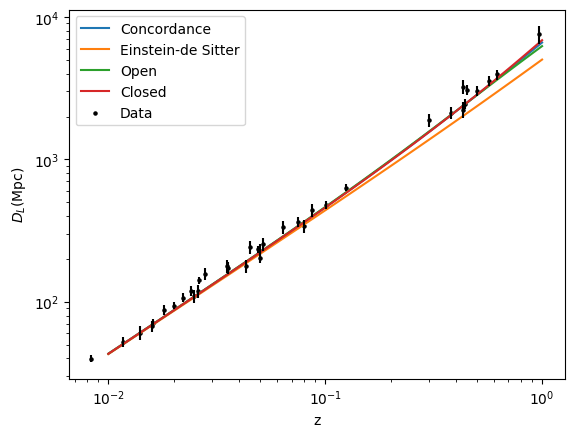

In [20]:
# Plotting some models versus data
zz = np.logspace(np.log10(0.01), np.log10(1), 100)

models = (
    (0.3, 0.7, 70),
    (1.0, 0.0, 70),
    (0.6, 1.0, 70),
    (0.1, 0.5, 70),
)

labels = (
    "Concordance",
    "Einstein-de Sitter",
    "Open",
    "Closed",
)

for model, label in zip(models, labels):
    lum_dists = [lum_dist(z, *model) for z in zz]
    plt.plot(zz, lum_dists, label=label)

for sn in all:
    plt.scatter(sn.z, sn.DL, color="black", s=5, label="Data" if sn.name=="1995ak" else "")
    plt.errorbar(sn.z, sn.DL, yerr=sn.sigma_DL, color="black")
plt.legend(loc="upper left")
plt.xlabel("z")
plt.ylabel(r"$D_L(\mathrm{Mpc})$")
plt.xscale("log")
plt.yscale("log")

Supernovae at very low redshifts cannot pick the acceleration of the expansion. At redshifts $z \geq 0.3$, supernovae can discriminate between Einstein-de Sitter and an Universe with dark energy!

From the data, we can construct the $\chi^2$ statistic, which measures the residuals between theoretical predictions and data, weighted by the uncertainty in the data points:

$$\chi^2 = \sum_i \frac{(\mu_i - \mu_\mathrm{th}(z_i, \Omega_m, \Omega_\Lambda, H_0))^2}{\sigma_i^2}$$

This quantity can be thought of a *goodness-of-fit* measurement: models with a smaller $\chi^2$ fit the data better

In [21]:
def chi2(model):
    global mus, sigmas
    om, ol, h0 = model
    if np.any(om*(1+zs)**3 + (1 - om - ol)*(1+zs)**2 + ol < 0): return np.nan
    lum_dists = np.array([lum_dist(z, *model) for z in zs])
    mus_th = 5*np.log10(lum_dists) + 25
    return np.sum((mus_th - mus)**2/sigmas**2)

for model, label in zip(models, labels):
    print(f"{label}: \chi^2 = {chi2(model):.1f}")

Concordance: \chi^2 = 72.1
Einstein-de Sitter: \chi^2 = 167.6
Open: \chi^2 = 72.3
Closed: \chi^2 = 72.3


Bayesian data analysis is the current paradigm in cosmology. This paradigm relies on the idea that model parameters are random variables, and their probability distribution is a measure of confidence. The Bayes theorem can be stated as:

$$ p(\Omega_m, \Omega_\Lambda, H_0 | \mathrm{data}) = \frac{p(\mathrm{data} | \Omega_m, \Omega_\Lambda, H_0) p(\Omega_m, \Omega_\Lambda, H_0)}{p(\mathrm{data})} $$

And can be interpreted in the following way:
- $p(\Omega_m, \Omega_\Lambda, H_0 | \mathrm{data})$ is the posterior distribution, the confidence you have in the model parameter values after taking the data into consideration;
- $p(\mathrm{data} | \Omega_m, \Omega_\Lambda, H_0)$ is the likelihood function, the probability of measuring the data assuming that the model is true;
- $p(\Omega_m, \Omega_\Lambda, H_0)$ is the prior distribution, the confidence you have in the cosmological parameter before taking the data into consideration;
- $p(\mathrm{data})$ is the Bayesian evidence, which does not depend on the model parameters.

We want to explore the posterior distribution to see which regions of the parameter space have the most probability. However, the parameter space is 3-dimensional. How can we do this?

Even with a 2-dimensional parameter space, it may be difficult to explore. Let's set $H_0 = 70\, \mathrm{km}\,\mathrm{s}^{-1}\,\mathrm{Mpc}^{-1}$ and explore. The simplest way to explore the parameter space is via rectangular grid sampling.

In [ ]:
oms = np.linspace(0, 2.5, 30)
ols = np.linspace(-1, 3, 30)
chi2s = {}
for om in oms:
    for ol in ols:
        chi2s[(om, ol)] = chi2((om, ol, 70))

/tmp/ipykernel_38290/1489899645.py:9: RuntimeWarning: invalid value encountered in sqrt
  integrand = lambda z: 1/np.sqrt((1+z)**2*(1+omegam*z) - z*(2+z)*omegal)
/tmp/ipykernel_38290/1489899645.py:10: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  integral = quad(integrand, 0, z)[0]
/tmp/ipykernel_38290/1775892886.py:6: RuntimeWarning: invalid value encountered in log10
  mus_th = 5*np.log10(lum_dists) + 25


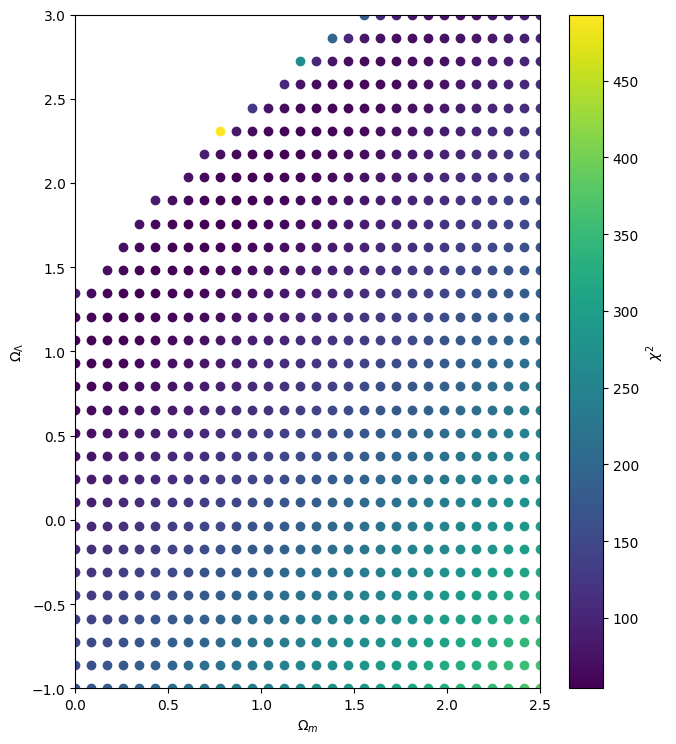

In [24]:
plt.figure(figsize=(30*0.25, 35*0.25))
min_chi2 = np.nanmin(np.array(list(chi2s.values())))
max_chi2 = np.nanmax(np.array(list(chi2s.values())))
for om in oms:
    for ol in ols:
        if chi2s[(om, ol)] is not None and not np.isnan(chi2s[(om, ol)]):
            plt.scatter(om, ol, c=chi2s[(om, ol)], cmap="viridis", norm=plt.Normalize(min_chi2, max_chi2))
plt.xlim([0, 2.5])
plt.ylim([-1, 3])
plt.xlabel(r"$\Omega_m$")
plt.ylabel(r"$\Omega_\Lambda$")
plt.colorbar(label=r"$\chi^2$")

The preferred region of the parameter space is the darker purple area. However, we are still not making any quantitative statements about the cosmological parameters...

The modern way to sample the parameter space is via Monte Carlo Markov Chains and the Metropolis-Hastings algorithm.

In [25]:
class MCMCWalker:
    def __init__(self):
        # Hard-coding an initial point for now
        initial_om = 0.3
        initial_ol = 0.7
        initial_h0 = 70
        initial_params = [initial_om, initial_ol, initial_h0]
        initial_chi2 = chi2(initial_params)
        if initial_chi2 == np.nan:
            self.__init__()
            return
        initial_sample = {
            'params': initial_params,
            'chi2': initial_chi2,
            'weight': 1,
        }
        self.samples = [initial_sample]

    def accept_sample(self, params, chi2):
        sample = {
            'params': params,
            'chi2': chi2,
            'weight': 1
        }
        self.samples.append(sample)

    def step(self):
        while True:
            current_chi2 = self.samples[-1]['chi2']
            new_om = self.samples[-1]['params'][0] + uniform(-0.25, 0.25)
            new_ol = self.samples[-1]['params'][1] + uniform(-0.25, 0.25)
            new_h0 = self.samples[-1]['params'][2] + uniform(-2.0, 2.0)
            new_params = [new_om, new_ol, new_h0]
            if new_h0 < 60 or new_h0 > 80 or new_om < 0 or new_om > 1 or new_ol < -1 or new_ol > 3:
                # Reject point outside the prior
                self.samples[-1]['weight'] += 1
                continue
            new_chi2 = chi2(new_params)
            if new_chi2 == np.nan:
                # Reject points that have problematic chi2
                self.samples[-1]['weight'] += 1
                continue
            if new_chi2 < current_chi2:
                self.accept_sample(new_params, new_chi2)
                break
            else:
                r = uniform(0, 1)
                if r < np.exp(-(new_chi2 - current_chi2)/2):
                    self.accept_sample(new_params, new_chi2)
                    break
                else:
                    self.samples[-1]['weight'] += 1 # Increment weight
                    continue
    
    def gelman_rubin(self, n_split):
        all_params = np.array(
            [sample['params'] for sample in self.samples]
        )[:-(len(self.samples)%n_split)]
        np.random.shuffle(all_params)
        split_params = np.split(all_params, n_split)
        avg = np.mean(split_params, axis=1)
        std = np.std(split_params, axis=1)
        avg_of_std = np.mean(std, axis=0)
        std_of_avg = np.std(avg, axis=0)
        R_minus_one = std_of_avg/avg_of_std
        return np.max(R_minus_one)

In [26]:
w = MCMCWalker()
while True:
    for _ in range(1000): w.step()
    R_minus_one = w.gelman_rubin(4)
    print(f"At {len(w.samples)} samples, R-1 = {R_minus_one}")
    if R_minus_one < 0.005: break 
print("MCMC Converged!")

At 1001 samples, R-1 = 0.08396750417242416
At 2001 samples, R-1 = 0.04012697740140673
At 3001 samples, R-1 = 0.05223396611405669
At 4001 samples, R-1 = 0.03034950349507177
At 5001 samples, R-1 = 0.03202119183529971
At 6001 samples, R-1 = 0.03662913519658963
At 7001 samples, R-1 = 0.02195646372861381
At 8001 samples, R-1 = 0.02196864325091258
At 9001 samples, R-1 = 0.022999973490838297
At 10001 samples, R-1 = 0.025209491770077874
At 11001 samples, R-1 = 0.013635555936603557
At 12001 samples, R-1 = 0.020480954588348522
At 13001 samples, R-1 = 0.024298479663563174
At 14001 samples, R-1 = 0.02304719459874549
At 15001 samples, R-1 = 0.01571966236871597
At 16001 samples, R-1 = 0.018163132074139703
At 17001 samples, R-1 = 0.0114285185760145
At 18001 samples, R-1 = 0.01604656702804648
At 19001 samples, R-1 = 0.006582334677345725
At 20001 samples, R-1 = 0.016274381937715923
At 21001 samples, R-1 = 0.015572649168415614
At 22001 samples, R-1 = 0.0061399405381923336
At 23001 samples, R-1 = 0.01248

With the samples, we can use some software like [GetDist](https://getdist.readthedocs.io/en/latest/) to do statistical analysis and ploots of our samples. GetDist uses **kernel density estimation (KDE)** to transform the samples into a continuous distribution. The KDE technique is our of the scopr of this notebook.

In [30]:
mcmc = getdist.MCSamples(
    samples=np.array([sample['params'] for sample in w.samples]),
    weights=np.array([sample['weight'] for sample in w.samples]),
    names=["Omega_m", "Omega_Lambda", "H0"],
    labels=["\Omega_m", "\Omega_\Lambda", "H_0"],
    ranges={"Omega_m": (0, None)}
)
mcmc.removeBurn(0.5)

Removed no burn in


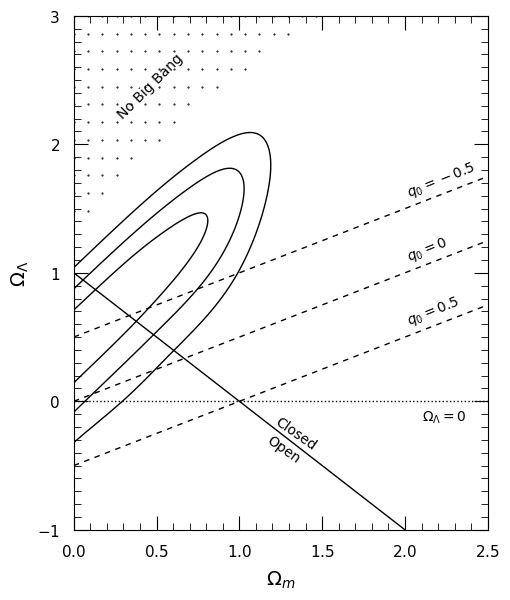

In [111]:
g = plots.get_single_plotter(width_inch=5, ratio=30/25)
g.settings.num_plot_contours = 3
ax = g.get_axes()
mcmc.updateSettings({"contours": [0.68, 0.95, 0.997]})
g.plot_2d(mcmc, "Omega_m", "Omega_Lambda", ls='-', lws=1)
ax.set_xlim([0, 2.5])
ax.set_ylim([-1, 3])

# Deceleration parameter lines
om = np.linspace(0, 2.5, 50)
ol = om/2 # q_0 = 0
ax.plot(om, ol, color="black", ls="--", lw=1, dashes=(4, 4))
ax.text(2.0, ol[-7], r"$q_0 = 0$", rotation=22)
ol = om/2 - 0.5 # q_0 = 0.5
ax.plot(om, ol, color="black", ls="--", lw=1, dashes=(4, 4))
ax.text(2.0, ol[-7], r"$q_0 = 0.5$", rotation=22)
ol = om/2 + 0.5 # q_0 = -0.5
ax.plot(om, ol, color="black", ls="--", lw=1, dashes=(4, 4))
ax.text(2.0, ol[-7], r"$q_0 = -0.5$", rotation=22)

# Closed/Open line
ol = 1 - om
ax.plot(om, ol, color="black", ls="-", lw=1)
ax.text(1.2, ol[-23], "Closed", rotation=-35)
ax.text(1.15, ol[-21], "Open", rotation=-35)

# Omega_Lambda = 0
ol = 0*om
ax.plot(om, ol, color="black", ls=":", lw=1)
ax.text(2.1, -0.15, r"$\Omega_\Lambda = 0$")

# No Big Bang points, we got them from a previous investigation
for om in oms:
    for ol in ols:
        if np.isnan(chi2s[(om, ol)]): ax.scatter(om, ol, c='black', marker='.', s=1)
ax.text(0.25, 2.2, "No Big Bang", rotation=45)

ax.set_xticks(np.arange(0, 2.51, 0.1), minor=True)
ax.set_yticks(np.arange(-1, 3, 0.1), minor=True)
ax.tick_params(direction="in", length=10, top=True, right=True, pad=10)
ax.tick_params(which="minor", direction="in", length=5, top=True, right=True)
g.export("riess_reproduction.pdf")

We got the plot! 